In [269]:
# default_exp funcs.merfish_eval

In [250]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# MERFISH routines

In [1]:
#export
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.plotting import *
from decode_fish.engine.noise import estimate_noise_scale
import shutil
from decode_fish.funcs.visualization import *
from decode_fish.funcs.predict import predict

from numba import njit
from scipy.spatial import cKDTree
from decode_fish.funcs.evaluation import matching

import io, requests
from sklearn.neighbors import NearestNeighbors
from starfish import data
import torch.tensor as T
import pprint

In [2]:
# export
def get_benchmark(magnitude_threshold=10**0.75*4):

    bench = pd.read_csv(
        io.BytesIO(requests.get('https://d2nhj9g34unfro.cloudfront.net/MERFISH/benchmark_results.csv').content),
        dtype={'barcode': object})

    #See Fig. S4 https://www.pnas.org/content/113/39/11046

    bench_df = bench.copy()
    bench_df = bench_df[bench_df['total_magnitude']>magnitude_threshold]
    bench_df = bench_df[bench_df['area']>3]

    print(len(bench_df))

    experiment = data.MERFISH(use_test_data=True)
    code_ref = experiment.codebook.data.reshape([140,-1], order='F')
    targets = experiment.codebook.indexes['target']
    
    return bench_df, code_ref, targets

In [3]:
bench_df, code_ref, targets = get_benchmark()

13832


In [443]:
pred_df = pd.read_csv('../data/results/MERFISH/exp_c3d_02noise.csv')
pred_df = exclude_borders(pred_df, border_size_zyx=[0,4000,4000], img_size=[2048*100,2048*100,2048*100])
pred_df.loc[pred_df['frame_idx']>7] = shift_df(pred_df[pred_df['frame_idx']>7], [5,20,0])
pred_df.loc[:,'comb_sig'] = 100*(pred_df.loc[:,'comb_sig']-1)
len(pred_df)

303099

In [271]:
# from decode_fish.funcs.routines import filt_perc
# pred_df = filt_perc(pred_df, 50, return_low=True, metric='comb_sig')

In [272]:
# pred_df0 = pd.read_csv('../data/results/MERFISH/exp_3_ch0.csv')
# pred_df1 = pd.read_csv('../data/results/MERFISH/exp_3_ch1.csv')
# pred_df1['frame_idx'] += 8
# pred_df1['loc_idx'] += pred_df0['loc_idx'].values[-1] + 1
# pred_df = pred_df0.append(pred_df1)
# pred_df = pred_df.reset_index(drop=True)
# pred_df.loc[:,'comb_sig'] = 100*(pred_df.loc[:,'comb_sig']-1)
# len(pred_df)

100%|███████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 295.48it/s]


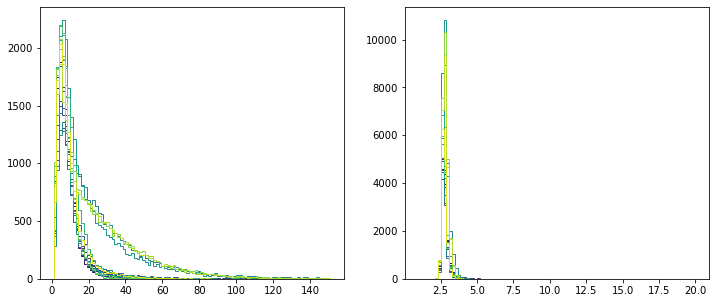

In [273]:
import seaborn as sns
plt.figure(figsize=(12,5))
plt.subplot(121)
cmap = sns.color_palette("viridis", n_colors=16)

for i in tqdm(range(0,16)):
    color='red' if i<8 else 'green'
    df1 = pred_df[pred_df['frame_idx']==i].copy()
    plt.hist(df1['comb_sig'], histtype='step', bins=np.linspace(1,151,101),color=cmap[i])
plt.subplot(122)
for i in tqdm(range(0,16)):
    color='red' if i<8 else 'green'
    df1 = pred_df[pred_df['frame_idx']==i].copy()
    plt.hist(df1['int'], histtype='step', color=cmap[i], bins=np.linspace(1,20,101))


In [369]:
#export
@njit
def index(array, item):
    for idx, val in np.ndenumerate(array):
        if val == item:
            return idx[0]
    return None

def get_bin_code(frame_idx, n_imgs=16):
    code = np.zeros(n_imgs, dtype='int8')
    code[frame_idx] = 1
    return code

def norm_features(code, norm_order = 2):
    
    norm = np.linalg.norm(code, ord=norm_order, axis=1)
    code = code / norm[:, None]

    return code

def approximate_nearest_code(ref_code, pred_code, targets):
    
    nn = NearestNeighbors(n_neighbors=1, algorithm='ball_tree', metric='euclidean').fit(ref_code)
    metric_output, indices = nn.kneighbors(pred_code)
    gene_ids = np.ravel(targets.values[indices])

    return np.ravel(metric_output), gene_ids, indices

def vcorrcoef(X,y):
    Xm = np.reshape(np.mean(X,axis=1),(X.shape[0],1))
    ym = np.mean(y)
    r_num = np.sum((X-Xm)*(y-ym),axis=1)
    r_den = np.sqrt(np.sum((X-Xm)**2,axis=1)*np.sum((y-ym)**2))
    r = r_num/r_den
    return r

In [370]:
#export
def code_from_groups(loc_df):
    
    # Extracts binary codes from grouping results.
    
    loc_df = loc_df[loc_df['group_idx'] > 0]
    
    # Sort by index
    loc_df = loc_df.sort_values('group_idx').reset_index(drop=True)
    group_idx = loc_df['group_idx'].values
    group_idx = np.array(group_idx, dtype=np.uint32)

    # Find group borders by diffing.
    inds = np.where(np.diff(group_idx))[0] + 1
    
    xy = loc_df.loc[:,['x','y']].values
    xy_sig = loc_df.loc[:,['x_sig','y_sig']].values
    ints = loc_df.loc[:,'int'].values
    frame_idx = loc_df.loc[:,'frame_idx'].values
    
    codes, rmses, cc, intsum, logs = [], [], [], [], []
    
    for i in tqdm(range(len(inds)-1)):
        
        sl = np.s_[inds[i]:inds[i+1]]
        
        code = get_bin_code(frame_idx[sl])
        codes.append(code)
        cc.append(code.sum())
        
        # Assigns various metrics to each group that could be used for filtering. 
        
        rmses.append(np.sqrt(np.mean((xy[sl] - xy[sl].mean(0))**2)))
        intsum.append(ints[sl].sum())

        # Get for all combinations of emitter within the group, weighted by their sigma.
        log_dists = torch.distributions.normal.Normal(T([0,0]), torch.sqrt(T(xy_sig[sl][None])**2 + T(xy_sig[sl][:,None])**2)). \
                                             log_prob(T(xy[sl][None]) - T(xy[sl][:,None])).sum(-1)
        
        log_dists = torch.triu(log_dists, diagonal=1)
        logs.append(log_dists.sum()/torch.count_nonzero(log_dists))

    res_df = loc_df.iloc[inds[:-1]].copy()
    res_df['code'] = codes
    res_df['cc'] = cc
    res_df['rmses'] = rmses
    res_df['int'] = intsum
    res_df['logdist'] = np.array(logs)
    
    return res_df

In [491]:
# export
def group_rounds_seq(pred_df, group_rad=150):
    
    # Simple sequential grouping, start with emitters in first round, then loop over other rounds grouping the closest emitter from each round within group_rad.

    loc_df=pred_df.copy()
    N_imgs = loc_df['frame_idx'].max() + 1

    loc_df['group_idx'] = -1

    group_count = 0

    for i in tqdm(range(0, N_imgs-1)):

        i_inds = (loc_df['frame_idx'] == i) & (loc_df['group_idx'] == -1)
        i_df = loc_df[(loc_df['frame_idx'] == i) & (loc_df['group_idx'] == -1)].reset_index(drop=True)
        loc_df.loc[i_inds,'group_idx'] = np.arange(len(i_df)) + group_count
        i_df.loc[:,'group_idx'] = np.arange(len(i_df)) + group_count
        group_count += len(i_df)

        tree = cKDTree(i_df.loc[:,['x','y']].values)

        for k in range(i+1, N_imgs):

            k_df = loc_df[(loc_df['frame_idx'] == k) & (loc_df['group_idx'] == -1)].reset_index(drop=True)
            dists, inds = tree.query(k_df.loc[:,['x','y']].values, distance_upper_bound=group_rad) 

            i_inds, k_inds = np.unique(inds, return_index=True)
            k_inds = list(k_inds[:-1])
            i_inds = list(i_inds[:-1])

            loc_inds = k_df['loc_idx'].values[k_inds]
            loc_df.loc[loc_inds,'group_idx'] = i_df.loc[i_inds,'group_idx'].values
    
    return loc_df

In [492]:
grouped_df = group_rounds_seq(pred_df, 150)

100%|████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.96it/s]


In [293]:
# export
def group_rounds_n_nearest(pred_df, group_rad=150, n_nearest=15):
    
    # Start with emitters in first round, group n_nearest emitters from all following imaging rounds. 

    loc_df=pred_df.copy()

    N_imgs = loc_df['frame_idx'].max() + 1

    loc_df['group_idx'] = -1
    loc_df['group_logs'] = 0
    print(len(loc_df))

    group_count = 0

    for i in tqdm(range(0, N_imgs)):

        i_inds = (loc_df['frame_idx'] == i) & (loc_df['group_idx'] == -1)
        i_df = loc_df[(loc_df['frame_idx'] == i) & (loc_df['group_idx'] == -1)].reset_index(drop=True)
        i_df.loc[:,'group_idx'] = np.arange(len(i_df)) + group_count
        loc_df.loc[i_inds,'group_idx'] = np.arange(len(i_df)) + group_count
        group_count += len(i_df)

        k_df = loc_df[(loc_df['frame_idx'] > i) & (loc_df['group_idx'] == -1)].reset_index(drop=True)

        tree = cKDTree(k_df.loc[:,['x','y']].values)
        dists, inds = tree.query(i_df.loc[:,['x','y']].values, k = n_nearest, distance_upper_bound=group_rad) 

        for n in range(n_nearest):

            k_inds, i_inds = np.unique(inds[:, n], return_index=True)
            k_inds = list(k_inds[:-1])
            i_inds = list(i_inds[:-1])


            loc_inds = k_df['loc_idx'].values[k_inds]
            loc_df.loc[loc_inds,'group_idx'] = i_df.loc[i_inds,'group_idx'].values

    return loc_df

In [294]:
grouped_df = group_rounds_n_nearest(pred_df, group_rad=150, n_nearest=15)

  6%|███▊                                                         | 1/16 [00:00<00:02,  5.56it/s]

246902


100%|████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16.29it/s]


In [295]:
# export
import torch.tensor as T
def group_logorder(pred_df, group_rad=150, log_lim=-500):
    
    # Get neighbours withing group rad. Calculate the sigma weighted distance (as log prob) for all neighbours.
    # Loop through them starting with cosest ones. Limit the lenght of groups to 4. 
    loc_df=pred_df.copy().reset_index(drop=True)
    
    N_imgs = loc_df['frame_idx'].max() + 1

    loc_df['group_idx'] = 0

    tree1 = cKDTree(loc_df.loc[:,['x','y']].values)
    tree2 = cKDTree(loc_df.loc[:,['x','y']].values)

    sdm = tree1.sparse_distance_matrix(tree2, group_rad, output_type='ndarray')

    frame_filt = loc_df['frame_idx'].values[sdm['i']] != loc_df['frame_idx'].values[sdm['j']]

    dists = sdm['v'][frame_filt]
    k_inds = sdm['i'][frame_filt]
    i_inds = sdm['j'][frame_filt]

    log_dists = torch.distributions.normal.Normal(T([0,0]), torch.sqrt(T(loc_df.loc[i_inds,['x_sig','y_sig']].values)**2 +
                                                                       T(loc_df.loc[k_inds,['x_sig','y_sig']].values)**2)). \
                                                                       log_prob(T(loc_df.loc[k_inds,['x','y']].values) - T(loc_df.loc[i_inds,['x','y']].values))

    log_dists = log_dists.sum(-1)
    inds = np.argsort(log_dists).flip(0)
    # Every entry is double because the pointclouds are the same. 
    log_dists, k_inds, i_inds = [s[inds][::2] for s in [log_dists, k_inds, i_inds]]

    if log_lim:
        inds = log_dists > log_lim
        log_dists, k_inds, i_inds = [s[inds] for s in [log_dists, k_inds, i_inds]]

#     return group_idx, log_dists, k_inds, i_inds
#     group_idx = log_loop(np.array(group_idx), np.array(log_dists), np.array(k_inds), np.array(i_inds))
    
    group_count = 1
    # Operate on array for much faster calculations
    group_idx = np.array(loc_df['group_idx'].values, dtype=np.uint32)

    for d, k, i in tqdm(zip(np.array(log_dists), np.array(k_inds, dtype=np.uint32), np.array(i_inds, dtype=np.uint32))):
        
        i_gidx = group_idx[i]
        k_gidx = group_idx[k]
        
        sum_gidx = i_gidx + k_gidx
        
        if not sum_gidx:
            # Both not grouped, create new group
            group_idx[i] = group_count
            group_idx[k] = group_count
            group_count += 1     
        else:
            if not k_gidx:
                # k not grouped, i grouped. Assign k to i group
                if np.count_nonzero(group_idx == i_gidx) < 4:
                    group_idx[k] = i_gidx  
            elif not i_gidx:
                # i not grouped, k grouped. Assign i to k group
                if np.count_nonzero(group_idx == k_gidx) < 4:
                    group_idx[i] = k_gidx   
            else:
                if k_gidx != i_gidx:
                    # Both grouped in different groups. Connect if len <= 5
                    if np.count_nonzero(group_idx == k_gidx) + np.count_nonzero(group_idx == i_gidx) <= 5:
                        group_idx[group_idx == k_gidx] = i_gidx  

    loc_df['group_idx'] = group_idx
    
    return loc_df

In [296]:
grouped_df = group_logorder(pred_df, group_rad=150, log_lim=None)

1301541it [02:11, 9889.81it/s] 


In [494]:
res_df = code_from_groups(loc_df)

100%|████████████████████████████████████████████████████| 84016/84016 [00:41<00:00, 2036.69it/s]


In [466]:
# export
def code_from_xy_logs(pred_df, code_ref, targets, group_rad=150, prob_smoothing=1):
    
    # Instead of grouping detections, we instead evaluate some metric (logprob) at a specific coordinate 
    # across channels and then find the closes code.
    
    norm_code = norm_features(code_ref) 

    loc_df=pred_df.copy()

    N_imgs = loc_df['frame_idx'].max() + 1

    loc_df = loc_df.sort_values('comb_sig').reset_index(drop=True)

    xy = loc_df.loc[:,['x','y']].values
    xy_sig = loc_df.loc[:,['x_sig','y_sig']].values * prob_smoothing
    fr_idx = loc_df.loc[:,'frame_idx'].values
    grouped_bool = np.zeros(len(loc_df))

    tree = cKDTree(xy)
    code_errs = []

    seed_inds = []
    code_err = []
    code_ind = []

    for i in tqdm(range(len(loc_df))):
#     for i in tqdm(range(15000)):    
        if not grouped_bool[i]:

            ball_inds = np.array(tree.query_ball_point(xy[i], group_rad))
            ball_inds = ball_inds[grouped_bool[ball_inds] == 0]

            if len(ball_inds) >= 4:

                frame_probs = np.zeros(N_imgs)
                
                # Evaluate probs at the position of the seed localization
#                 probs = torch.exp(torch.distributions.normal.Normal(T(xy[ball_inds]), T(xy_sig[ball_inds])).log_prob(T(xy[i])).sum(-1))
                
                cdf = torch.distributions.normal.Normal(T([0,0]), (torch.sqrt(T(xy_sig[ball_inds][None])**2 + T(xy_sig[ball_inds][:,None])**2))).cdf(-abs(T(xy[ball_inds][None]) - T(xy[ball_inds][:,None]))).prod(-1)
                cdf = cdf*(1-torch.diag(torch.ones(len(cdf))))
                probs = (cdf*4).sum(0)/(len(cdf) - 1)                
                
                # If multiple localizations belong the same frame, chose the one with higehst prob.
                sort_inds = np.argsort(-probs)
                sort_fr_idx = fr_idx[ball_inds][sort_inds]
                unique_inds = sort_inds[np.unique(sort_fr_idx, return_index=True)[1]] 
                
                if len(unique_inds) >= 4:
                    
                    ball_inds = ball_inds[unique_inds]
                    frame_probs[fr_idx[ball_inds]] = probs[unique_inds]
                    
#                     frame_probs = np.clip(frame_probs,0.,np.sort(frame_probs[frame_probs.nonzero()])[1])
#                     frame_probs = frame_probs**(1/prob_smoothing)
#                     code_errors = np.sqrt(((norm_code - norm_features(frame_probs[None]))**2).sum(-1))

#                     frame_probs = frame_probs/frame_probs.max()
#                     code_errors = np.sqrt(((code_ref - (frame_probs[None]))**2).sum(-1))
            
#                     frame_probs = frame_probs**(1/prob_smoothing)
                    code_errors = 1-vcorrcoef(code_ref, frame_probs)

                    min_ind = np.argmin(code_errors)

                    selected = ball_inds[np.intersect1d(fr_idx[ball_inds], code_ref[min_ind].nonzero()[0], assume_unique=True, return_indices=True)[1]]

                    grouped_bool[selected] = 1

                    seed_inds.append(i)
                    code_err.append(code_errors[min_ind])
                    code_ind.append(min_ind)

                    loc_df.loc[i,['ch_err']] = np.array(frame_probs, dtype='object')

    loc_df = loc_df.loc[seed_inds]
    loc_df['code_err'] = code_err
    loc_df['code_inds'] = code_ind
    loc_df['gene'] = targets[code_ind]

    return loc_df

In [467]:
res_df = code_from_xy_logs(pred_df, code_ref, targets, group_rad=150, prob_smoothing=1)
res_df_filt = res_df

  0%|                                                                 | 0/303099 [00:00<?, ?it/s]

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.38555832e-01 0.00000000e+00
 2.10727167e-05 0.00000000e+00 1.18083546e-01 8.70636831e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]


ValueError: Must have equal len keys and value when setting with an iterable

In [502]:
pred_df.loc[[720,721],'x'] = [np.array([99,99,99], dtype='object'), np.array([99,99,99], dtype='object')]

ValueError: Must have equal len keys and value when setting with an ndarray

In [483]:
import pandas as pd
import numpy as np


df=pd.DataFrame(np.arange(20).reshape(5,4), columns=list('abcd'))
df=df.astype(object)  # this line allows the signment of the array
df.loc[0,'b'] = np.array([99,99,99])
print(df)

    a             b   c   d
0   0  [99, 99, 99]   2   3
1   4             5   6   7
2   8             9  10  11
3  12            13  14  15
4  16            17  18  19


In [382]:
# # # Save as csv
# res_df.to_pickle('../data/results/MERFISH/exp_02met.pickle')
# # # Load from csv
# # res_df = pd.read_pickle('../data/results/MERFISH/exp_02met.pickle')

In [416]:
def match_codes(res_df, code_ref, targets, metric_lim=1.25, cc_lim=3, plot=True):
    
    code_all = np.stack(res_df['code'])
    res_df_filt = res_df[res_df['cc'] >= cc_lim]
    
    code_pred = np.stack(res_df_filt['code'])
    
    metric_outputs, pred_targets, _ = approximate_nearest_code(code_ref, code_pred, targets)
    
    preds_filt = pred_targets[metric_outputs <= metric_lim]
    
    res_df_filt = res_df_filt[metric_outputs <= metric_lim]
    res_df_filt['gene'] = preds_filt
    
    if plot:
        
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        plt.hist(metric_outputs)
        plt.subplot(122)
        plt.hist(res_df['cc'].values, bins=np.linspace(0.5,16.5,17), facecolor='None', edgecolor='blue')
        plt.show()        
    
    return res_df_filt

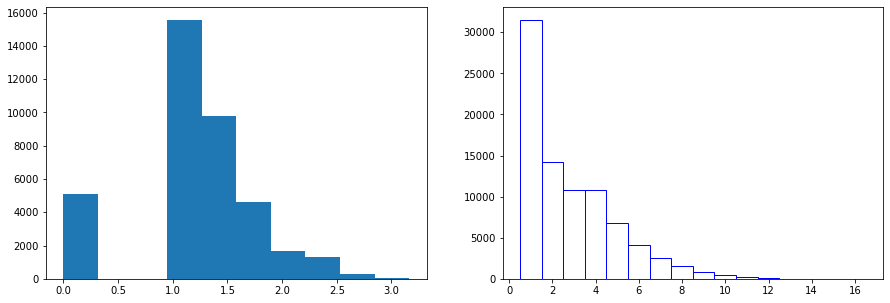

In [335]:
res_df_filt = match_codes(res_df, code_ref, targets, metric_lim=1.25, cc_lim=3)

In [375]:
# export
def match_bench(pred_df, bench_df):

    bench_match = bench_df.copy()
    bench_match.loc[:,'frame_idx'] = 0
    bench_match.loc[:,'loc_idx'] = np.arange(len(bench_match))
    bench_match.loc[:,'int'] = bench_match['total_magnitude']
    bench_match.loc[:,'z'] = 50/100
    bench_match = px_to_nm(bench_match)

    pred_df.loc[:,'frame_idx'] = 0

    _,_,shift = matching(bench_match, pred_df, tolerance=250, print_res=False)
    print(shift)
    bench_match = shift_df(bench_match, shift=-np.array(shift))

    _,_,shift = matching(bench_match, pred_df, tolerance=250, print_res=False)

    bench_match = shift_df(bench_match, shift=-np.array(shift))
    _,matches,shift = matching(bench_match, pred_df, tolerance=250, print_res=True)
    
    return matches, bench_match

In [397]:
matches = match_bench(res_df_filt, bench_df)

[64.960898373583, 60.568250152784685, -49.45371823548546]
Recall: 0.779
Precision: 0.208
Jaccard: 19.632
RMSE_vol: 98.003
Eff_3d: 5.871
FN: 3063.0 FP: 41023.0
Num. matches: 10769.000
Shift: 6.47,6.42,0.25


In [403]:
res_sub = res_df_filt[:17500]

In [404]:
bench_counts = DF(data=None, index=targets)
bench_counts['Res_all'] = res_sub.groupby('gene')['gene'].count()
bench_counts['Bench_all'] = bench_df.groupby('gene')['gene'].count()
bench_counts = bench_counts.fillna(0)

fps = res_sub.loc[~res_sub['loc_idx'].isin(matches['pred_idx'])]
fns = bench_match.loc[~bench_match['loc_idx'].isin(matches['tar_idx'])]

bench_counts['Res_fp'] = fps.groupby('gene')['gene'].count()
bench_counts['Res_fns'] = fns.groupby('gene')['gene'].count()
bench_counts=bench_counts.fillna(0)

In [421]:
bench_match

,Unnamed: 0,barcode,barcode_id,fov_id,total_magnitude,area,is_exact,error_bit,error_dir,av_distance,x,y,wx,wy,gene,frame_idx,loc_idx,int,z
36077,36077,0100010000000110,118,0,1384.199097,25,1,0,0,0.215145,50103.284385,171811.391857,502.137329,1718.291016,PRKCA,0,0,1384.199097,50.0
41565,41565,0000001100010010,133,0,363.853851,19,1,0,0,0.231969,94903.284385,91811.391857,949.749451,918.989380,ZNF592,0,1,363.853851,50.0
17886,17886,1101000001000000,58,0,172.294464,11,1,0,0,0.232641,131703.284385,169211.391857,1317.923340,1692.893677,PRKDC,0,2,172.294464,50.0
41519,41519,0000001100010010,133,0,374.844757,21,1,0,0,0.233086,73603.284385,58611.391857,736.608093,586.647888,ZNF592,0,3,374.844757,50.0
5831,5831,1001000000101000,25,0,227.410797,19,1,0,0,0.237320,12403.284385,103611.391857,124.526085,1036.598145,HERC2,0,4,227.410797,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23192,23192,0001000000110001,75,0,74.323936,4,0,4,1,0.507635,27603.284385,173711.391857,277.288788,1738.436523,MAN1A2,0,13827,74.323936,50.0
23826,23826,0001000100010100,76,0,150.026352,4,1,0,0,0.508210,56803.284385,152811.391857,568.681702,1528.673096,SPTBN1,0,13828,150.026352,50.0
7966,7966,0010000010011000,33,0,80.690697,4,0,9,1,0.508272,82303.284385,95911.391857,823.735657,959.794067,AFF4,0,13829,80.690697,50.0
26901,26901,0110001001000000,84,0,89.202225,5,0,10,1,0.509813,22803.284385,93311.391857,228.564896,934.090210,PTPN14,0,13830,89.202225,50.0


In [405]:
#export
def plot_gene_numbers(bench_counts, res_counts, title='', log=True, corr=True):
    
    if corr:
        r = np.corrcoef(bench_counts, res_counts)[0, 1]   
        r = np.round(r, decimals=3)
    else:
        r = np.sum(res_counts)
    x_lim = np.max([bench_counts.max(), res_counts.max()])
    x = np.linspace(0, x_lim)
    
    plt.scatter(bench_counts, res_counts, 50, zorder=2)
    plt.plot(x, x, '-k', zorder=1)

    plt.xlabel('Gene copy number Benchmark')
    plt.ylabel('Gene copy number DECODE')
    if log:
        plt.xscale('log')
        plt.yscale('log')
    plt.title(f'{title} r = {r}');

13832 17500


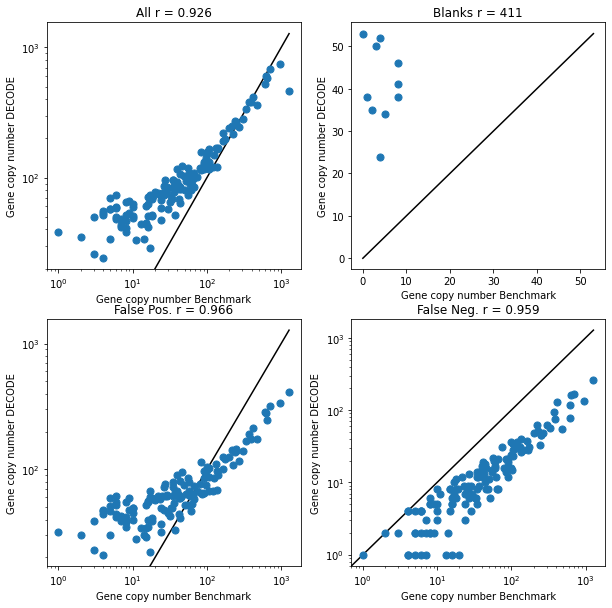

In [406]:
print(len(bench_df), len(res_sub))

plt.figure(figsize=(10,10))
plt.subplot(221)
plot_gene_numbers(bench_counts['Bench_all'].values, bench_counts['Res_all'].values, 'All', log=True)

binds = []
for i,g in enumerate(targets):
    if 'Blank' in g:
        binds.append(g)
        
plt.subplot(222)
plot_gene_numbers(bench_counts.loc[binds, 'Bench_all'].values, bench_counts.loc[binds,'Res_all'].values, 'Blanks', log=False, corr=False)

plt.subplot(223)
plot_gene_numbers(bench_counts['Bench_all'].values, bench_counts['Res_fp'].values, 'False Pos.', log=True)

plt.subplot(224)
plot_gene_numbers(bench_counts['Bench_all'].values, bench_counts['Res_fns'].values, 'False Neg.', log=True)

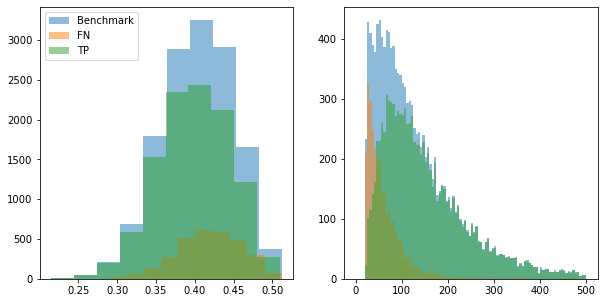

In [410]:
plt.figure(figsize=(10,5))
plt.subplot(121)
_ = plt.hist(bench_match['av_distance'], density=False, alpha=0.5, label='Benchmark')
_ = plt.hist(bench_match['av_distance'][~bench_match['loc_idx'].isin(matches['tar_idx'])], density=False, alpha=0.5, label='FN')
_ = plt.hist(bench_match['av_distance'][bench_match['loc_idx'].isin(matches['tar_idx'])], density=False, alpha=0.5, label='TP')
plt.legend()

plt.subplot(122)
_ = plt.hist(bench_match['total_magnitude'], density=False, bins=np.linspace(0,500,101), alpha=0.5, label='Benchmark')
_ = plt.hist(bench_match['total_magnitude'][~bench_match['loc_idx'].isin(matches['tar_idx'])], density=False, bins=np.linspace(0,500,101), alpha=0.5, label='FN')
_ = plt.hist(bench_match['total_magnitude'][bench_match['loc_idx'].isin(matches['tar_idx'])], density=False, bins=np.linspace(0,500,101), alpha=0.5, label='TP')

In [408]:
image_paths = sorted(glob.glob('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//datasets/CodFish/MERFISH/starfish/*.tiff'))

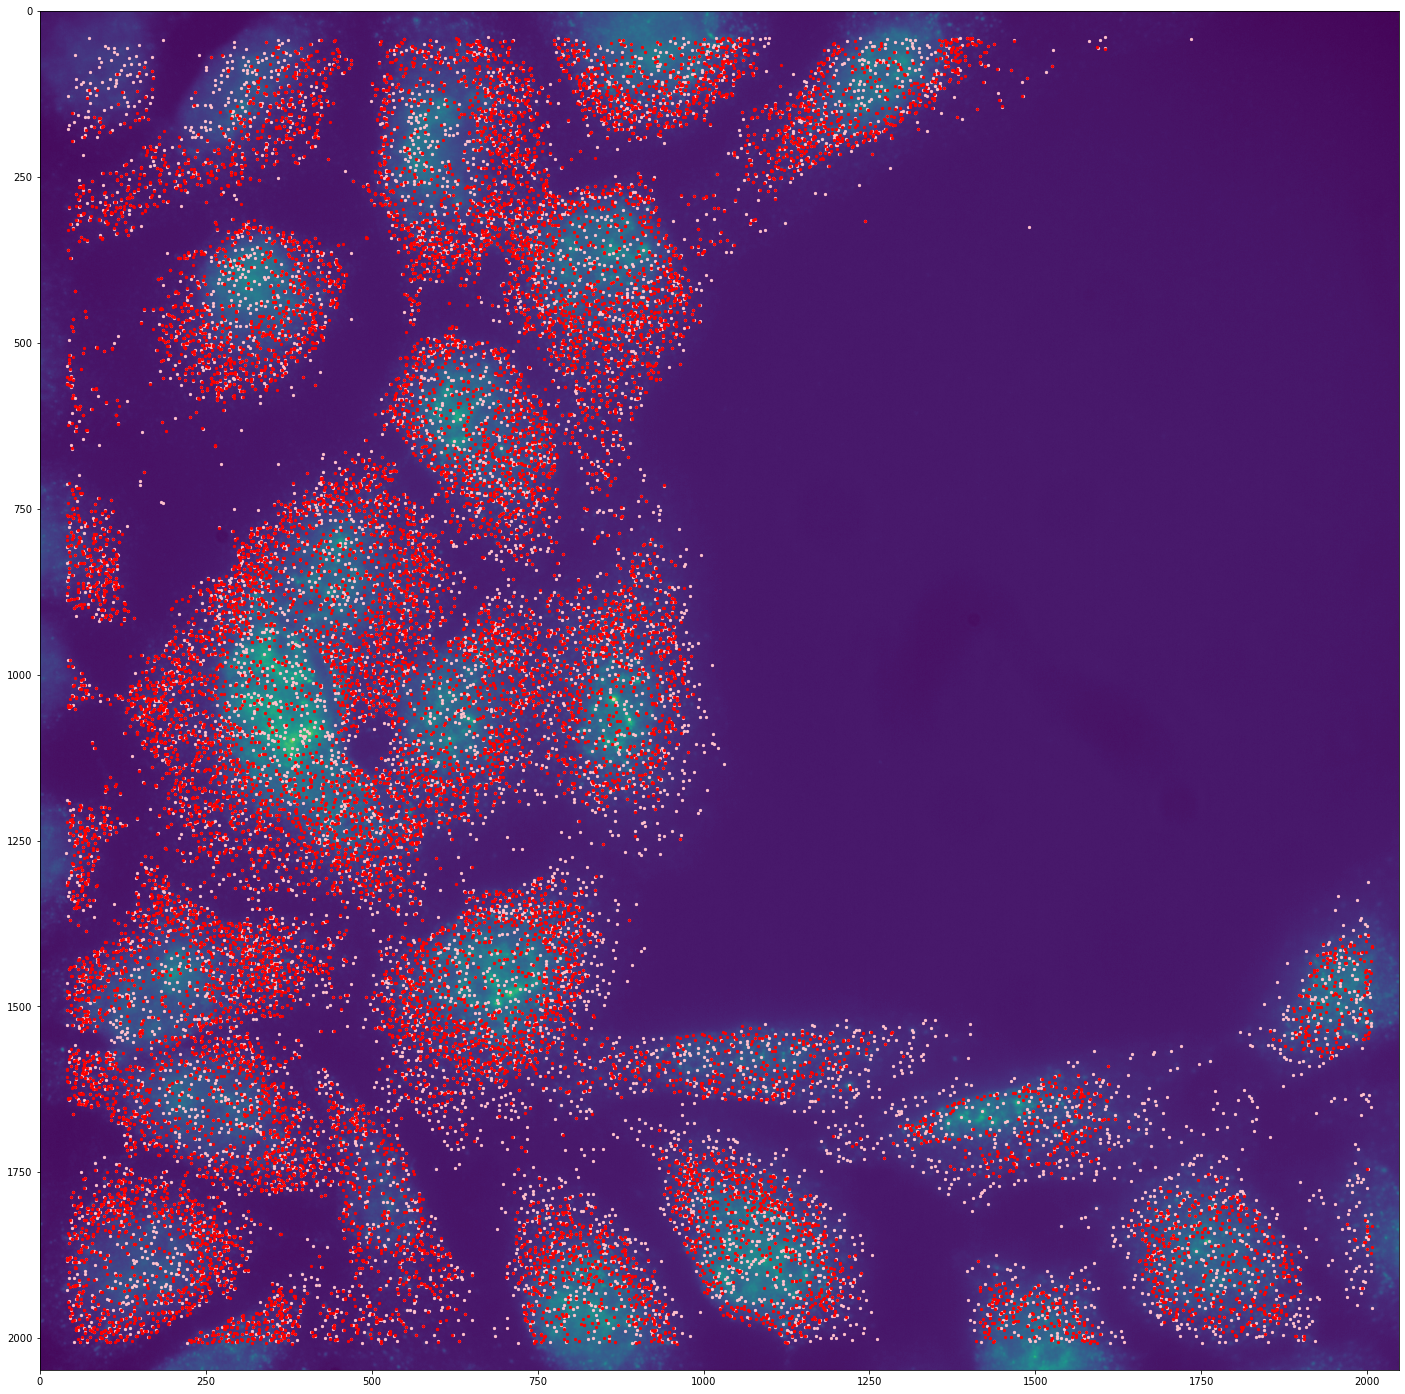

In [409]:
ind = 0
img = load_tiff_image(image_paths[ind])
preds_px = nm_to_px(res_sub)#[res_sub['gene']=='MALAT1']
bench_px = nm_to_px(bench_match)#[bench_match['gene']=='MALAT1']
plt.figure(figsize=(25,25))
plt.imshow(img[0,0])

plt.scatter(bench_px['x'],bench_px['y'], color='pink', s=5)
plt.scatter(preds_px['x'],preds_px['y'], color='red', s=5)

In [423]:
!nbdev_build_lib

Converted 00_models.ipynb.
Converted 01_psf.ipynb.
Converted 02_microscope.ipynb.
Converted 03_noise.ipynb.
Converted 04_pointsource.ipynb.
Converted 05_gmm_loss.ipynb.
Converted 06_plotting.ipynb.
Converted 07_file_io.ipynb.
Converted 08_dataset.ipynb.
Converted 09_output_trafo.ipynb.
Converted 10_evaluation.ipynb.
Converted 11_emitter_io.ipynb.
Converted 12_utils.ipynb.
Converted 13_train.ipynb.
Converted 15_fit_psf.ipynb.
Converted 16_visualization.ipynb.
Converted 17_eval_routines.ipynb.
Converted 18_predict_funcs.ipynb.
Converted 19_MERFISH_routines.ipynb.
Converted 20_MERFISH_visualization.ipynb.
Converted hyper.ipynb.
Converted index.ipynb.
